# Libraries

In [138]:
# import csv
# import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [139]:
# query = "Query_NYT_5y_surveillance"
query = "Query_NYT_13y_surveillance"
# query = "Query_US_5y_Svalbard"

FEATHER_FILE = query + ".feather"

df = pd.read_feather('data/' + FEATHER_FILE)
# df = df.drop(df[df['tags'].str.contains('None') == True].index)
# df = df.reset_index(drop=True)
df = df.drop('text_downloaded', axis=1)
df = df.drop('stories_id', axis=1)

df.sample(3)

,title,url,year,text,tags,GPE,IND,ORG
2008,5 Takeaways From the Greek Election,https://www.nytimes.com/2023/06/26/world/europ...,2023,Supported by\nHow New Democracy Surged to Vict...,"[{'label': 'politics and government', 'score':...","[Greece, Greece, Ukraine, Turkey, Greece, Gree...","[Kyriakos Mitsotakis, Kyriakos Mitsotakis, Mit...","[New Democracy party, the European Union, the ..."
1644,Biden Tries to Calm Tensions Over Chinese Spy ...,https://www.nytimes.com/2023/02/16/us/politics...,2023,Biden Tries to Calm Tensions Over Chinese Aeri...,"[{'label': 'armament, defense and military for...","[WASHINGTON, Beijing, China, the United States...","[Xi Jinping, Biden, Xi Jinping, Biden, Biden, ...","[Biden Tries to Calm Tensions Over, Capitol Hi..."
2893,"Corrections: June 20, 2014",http://www.nytimes.com/2014/06/20/pageoneplus/...,2014,"Supported by\nCorrections: June 20, 2014\nINTE...","[{'label': 'international relations', 'score':...","[Melilla, Ceuta, West Africa, Iraq, Syria, Ira...","[Mustafa Maya Amaya, Justin M. Leverenz, Rajee...","[INTERNATIONAL, the Islamic State, Oppenheimer..."


## Cleaning

In [140]:
df = df[df['url'].apply(lambda x: 'www.nytimes.com/live/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/briefing/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/topic/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/podcast/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/dealbook/' not in x)]
df = df.reset_index(drop=True)




## Cleaning

In [141]:
for index, row in df.iterrows():

    ind = row["IND"]
    org = row["ORG"]
    gpe = row["GPE"]

    # print(org)

    ind = [a for a in ind if (" " in a)]  # remove ind without space
    ind = [a for a in ind if ("\n" not in a)]  # remove ind with \n

    ind = list(map(lambda x: x.replace(".", ""), ind)) # remove dots
    ind = list(map(lambda x: re.sub(' [A-Z]* ', ' ', x), ind)) # remove middle initial

    ind = list(map(lambda x: x.replace("De ", "\xa0"), ind)) # add non breaking space
    ind = list(map(lambda x: x.replace("de ", "\xa0"), ind)) # add non breaking space

    org = list(map(lambda x: x.replace("The ", ""), org))
    org = list(map(lambda x: x.replace("the ", ""), org))

    org = list(map(lambda x: x.replace(".", ""), org))
    
    gpe = list(map(lambda x: x.replace(".", ""), gpe))

    # print(org)

    df.loc[index, "IND"] = ind
    df.loc[index, "ORG"] = org
    df.loc[index, "GPE"] = gpe

## Set tags

In [142]:
all_tags = []

for index, row in df.iterrows():

    tags = []

    for i, tag in enumerate(row["tags"]):
        if i < 3:
            tags.append(tag["label"])

    all_tags.append(tags)

df['TAG'] = all_tags
df = df.drop(columns=['tags'])

df.sample()

,title,url,year,text,GPE,IND,ORG,TAG
2086,Whistle-Blower on N.S.A. Wiretapping Is Set to...,http://www.nytimes.com/2016/07/13/us/politics/...,2016,WASHINGTON — A District of Columbia bar commit...,"[WASHINGTON, A District of Columbia, Maryland]","[Thomas Tamm, Paul Kemp, James Risen, Eric Lic...","[Justice Department, New York Times, National ...",[wiretapping and other eavesdropping devices a...


## Clean Years

In [143]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{'2013', '2020', '2017', '2023', '2019', '2022', '2021', '2014', '2010', '2015', '2018', '2012', '2016', '2011'}


## Entities

In [144]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    tag = row["TAG"]
    
    cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    for entity in tag:
        update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 35983


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
0,China,gpe,6198,NaN,None,-1,-1,-1,"{'2010': 47, '2011': 4, '2012': 58, '2013': 15...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ..."


# Treatment

## Normalization

In [145]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
27181,Baruch College,org,3,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[http://www.nytimes.com/2016/06/17/nyregion/ol...,"[Old New York Police Surveillance Is Found, Fo...","[New York, Queens, Queens, New York, Chicago, ...",0.000323,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


## Filter

In [146]:
# Number of rows by type

max_gpe = 80
max_ind = 80
max_org = 80
max_tag = 60

top_gpe = (
    entities_all.loc[entities_all["type"] == "gpe"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_gpe)
)
top_ind = (
    entities_all.loc[entities_all["type"] == "ind"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_ind)
)
top_org = (
    entities_all.loc[entities_all["type"] == "org"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_org)
)
top_tag = (
    entities_all.loc[entities_all["type"] == "tag"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_tag)
)

entities = pd.concat([top_gpe, top_ind, top_org, top_tag])



# min_frequency = 80

# entities = (
#     entities_all[entities_all['frequency']>min_frequency]
#     .sort_values(by=["frequency"], ascending=False)
# )

len(entities)


300

In [147]:
entities.head(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
0,China,gpe,6198,NaN,None,-1,-1,-1,"{'2010': 47, '2011': 4, '2012': 58, '2013': 15...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ...",1.000000,"{""2010"": 47, ""2011"": 4, ""2012"": 58, ""2013"": 15..."
4,the United States,gpe,3864,NaN,None,-1,-1,-1,"{'2010': 47, '2011': 49, '2012': 57, '2013': 2...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ...",0.623366,"{""2010"": 47, ""2011"": 49, ""2012"": 57, ""2013"": 2..."
872,Russia,gpe,2526,NaN,None,-1,-1,-1,"{'2010': 28, '2011': 4, '2012': 4, '2013': 88,...",[https://www.nytimes.com/2018/12/28/us/politic...,[Departing House Republicans Try to Keep Inves...,"[WASHINGTON, Virginia, South Carolina, Russia,...",0.407455,"{""2010"": 28, ""2011"": 4, ""2012"": 4, ""2013"": 88,..."


## Linear Regression

In [148]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
724,children and youth,tag,125,0.500256,None,-1,-1,-1,"{'2010': 1, '2011': 3, '2012': 4, '2013': 5, '...",[https://www.nytimes.com/2018/12/24/business/m...,[Advertising: Sharing Data for Deals? More Lik...,"[California, Joseph Turow, Steve Satterfield, ...",0.02001,"{""2010"": 1, ""2011"": 3, ""2012"": 4, ""2013"": 5, ""..."


## Colors

In [149]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
0,China,gpe,6198,101.917775,#b40426,-1,-1,-1,"{'2010': 47, '2011': 4, '2012': 58, '2013': 15...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ...",1.0,"{""2010"": 47, ""2011"": 4, ""2012"": 58, ""2013"": 15..."


# Embedding

## Term Frequency

In [150]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

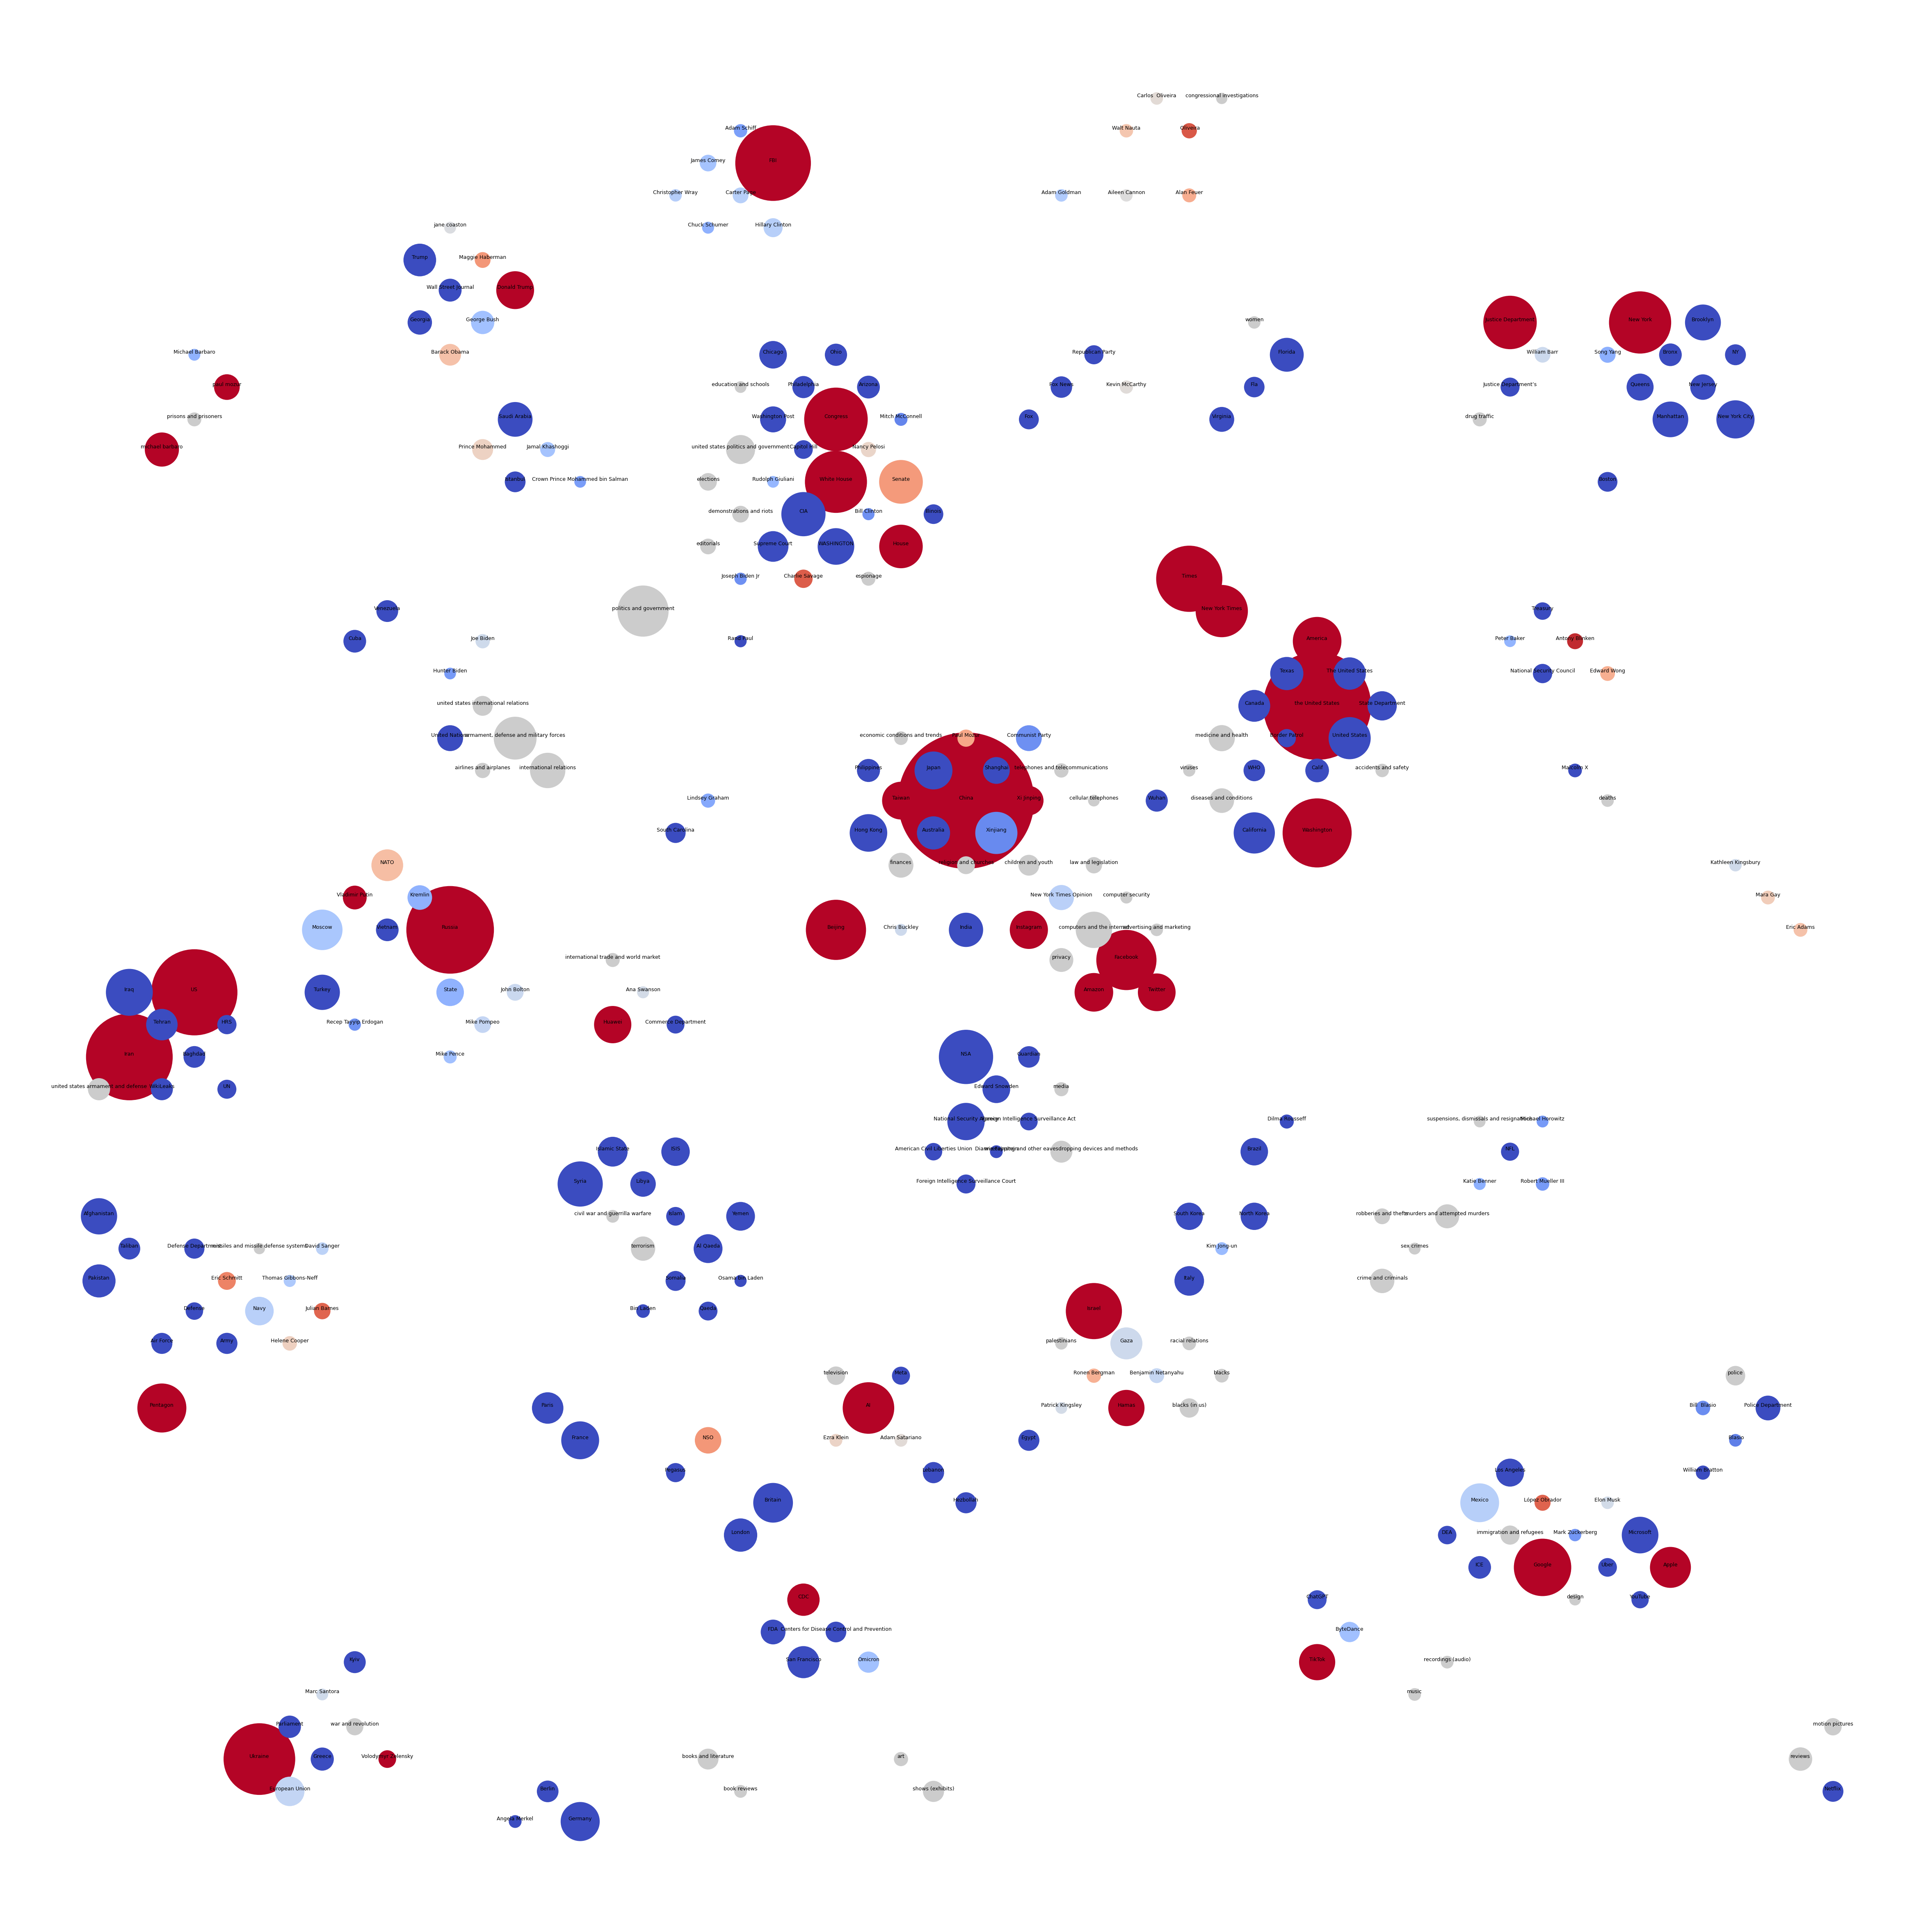

In [151]:
reducer = umap.UMAP(
    random_state=2,
    n_components=2,
    n_neighbors=2,
    min_dist=0.3,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [152]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2715,Vladimir Putin,ind,167,1.701456,#b40426,218,529,p_5,"{'2010': 1, '2011': 0, '2012': 2, '2013': 6, '...",[https://www.nytimes.com/interactive/2019/02/1...,[Trump Has Publicly Attacked the Russia Invest...,"[Russia, Iran, Russia, USA, Crimea, TAKEN, Rus...",0.026787,"{""2010"": 1, ""2011"": 0, ""2012"": 2, ""2013"": 6, ""..."


{'p_1', 'p_0', 'n_3', 'p_7', 'n_12', 'n_5', '-1', 'n_9', 'n_8', 'p_5', 'p_8', 'n_11', 'n_4', 'p_4', 'n_10', 'p_6', 'n_7', 'n_16', 'n_6', 'n_0', 'n_2', 'p_2', 'n_14', 'n_1', 'n_18', 'n_17', 'n_15', 'n_19', 'p_3', 'n_13'}
4
9
13
7
7
20
56
7
5
5
11
10
6
5
11
7
4
6
3
19
5
4
15
6
5
14
10
7
4
15


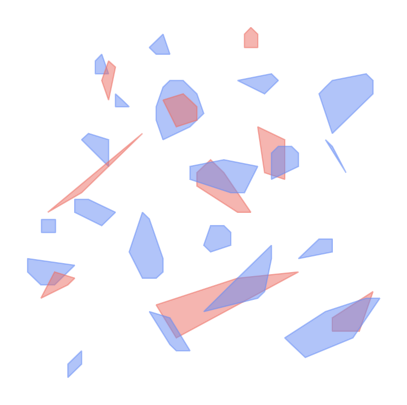

In [153]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [154]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
1675,Katie Benner,ind,36,-0.498544,#8db0fe,737,396,n_16,[https://www.nytimes.com/2019/01/28/us/politic...,0.005648,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."
